In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# path = "/content/drive/MyDrive/Sentiment-Analysis-using-BERT-master/Sentiment-Analysis-using-BERT-master/Data/"

In [1]:
import pickle
import pandas as pd
df = pd.read_csv("train.csv")
df = df.dropna()

In [2]:
data_train = df.review.to_list()
label_train = df.label.to_list()

In [3]:
#!pip install -q keras-bert==0.85.0
#!pip install -q keras-rectified-adam

In [ ]:
#%tensorflow_version 1.x

In [ ]:
#pip install keras==2.3.1

In [ ]:
# Install the required libraries
!pip install -q keras-bert==0.88.0
!pip install -q keras-radam==0.2.0

# Download and extract the BERT model
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

In [ ]:
# Download and extract the BERT model
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

In [ ]:
# Install the required versions of TensorFlow and Keras
!pip install tensorflow==2.10.1
!pip install keras==2.10.0

In [4]:
import codecs
import tensorflow as tf
import keras
import os
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
import numpy as np

2024-04-15 08:42:27.569464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 08:42:27.826806: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 08:42:28.872072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-15 08:42:28.872113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missi

In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
SEQ_LEN = 64  # Decrease sequence length
BATCH_SIZE = 16  # Increase batch size
EPOCHS = 5  # Decrease number of epochs
LR = 1e-5  # Decrease learning rate

In [7]:
#!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
#!unzip -o multi_cased_L-12_H-768_A-12.zip

In [8]:
pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [9]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    seq_len=SEQ_LEN,
    output_layer_num=4,
    trainable=True
)

2024-04-15 08:43:55.286510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 08:44:02.373318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2024-04-15 08:44:02.374766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9639 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-04-15 08:44:02.376012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/tas

In [10]:
from keras_bert import Tokenizer

token_dict = {}
with codecs.open(vocab_path, 'r', encoding='utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

tokenizer = Tokenizer(token_dict, cased=False)  # Update based on the model

In [ ]:
#from keras_bert import Tokenizer
#tokenizer = Tokenizer(token_dict,cased=True)

In [11]:
from keras_bert.layers import Extract
from keras.regularizers import l1
from keras.layers import LSTM,SpatialDropout1D

In [12]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 64, 768),   91812096    ['Input-Token[0][0]']            
 g)                              (119547, 768)]                                                   
                                                                                                  
 Embedding-Segment (Embedding)  (None, 64, 768)      1536        ['Input-Segment[0][0]']    

In [13]:
from keras.layers import Dense, LSTM, Reshape, SpatialDropout1D
from keras.models import Model

inputs = model.inputs[:2]
bert_out = Reshape((1, -1))(model.output)  # Reshape to match the expected input shape of SpatialDropout1D
bert_out = SpatialDropout1D(0.2)(bert_out)
l_lstm = LSTM(256)(bert_out)
newout = Dense(256, activation='relu')(l_lstm)
preds = Dense(units=1, activation='sigmoid')(newout)
model = Model(inputs, preds)

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=LR)

In [15]:
# Compile your model using the tf.keras optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
from sklearn.model_selection import train_test_split

def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
        ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
        indices.append(ids)

    return [np.array(indices), np.zeros_like(indices)], np.array(sentiments)

data_train, data_valid, label_train, label_valid = train_test_split(data_train, label_train, test_size=0.15, random_state=48)
X_train, Y_train = load_data(data_train, label_train)
X_valid, Y_valid = load_data(data_valid, label_valid)

In [17]:
test = pd.read_csv( 'test.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()
X_test, Y_test = load_data(data_test, label_test)

In [18]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('256_checkpoint_lstm_data1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=[X_valid, Y_valid], callbacks=callbacks_list)

y_pred = np.round(model.predict(X_test))

Epoch 1/5


2024-04-15 08:49:34.221988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8904


2125/2125 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.7586
Epoch 1: val_accuracy improved from -inf to 0.79550, saving model to 256_checkpoint_lstm_data1.h5
2125/2125 [==============================] - 393s 173ms/step - loss: 0.4787 - accuracy: 0.7586 - val_loss: 0.4450 - val_accuracy: 0.7955
Epoch 2/5
2125/2125 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8381
Epoch 2: val_accuracy improved from 0.79550 to 0.80317, saving model to 256_checkpoint_lstm_data1.h5
2125/2125 [==============================] - 503s 237ms/step - loss: 0.3557 - accuracy: 0.8381 - val_loss: 0.4194 - val_accuracy: 0.8032
Epoch 3/5
2125/2125 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9011
Epoch 3: val_accuracy improved from 0.80317 to 0.81067, saving model to 256_checkpoint_lstm_data1.h5
2125/2125 [==============================] - 481s 226ms/step - loss: 0.2391 - accuracy: 0.9011 - val_loss: 0.4790 - val_accuracy: 0.8107
Epoch 4/

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(Y_test, y_pred))
print(recall_score(Y_test, y_pred))
print(f1_score(Y_test, y_pred))

0.7736662475300881
0.8547330819607065
0.812181783895908


In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0, 1]
cn = confusion_matrix(Y_test, y_pred, labels=labels)

In [22]:
cn

array([[3701, 1260],
       [ 732, 4307]])

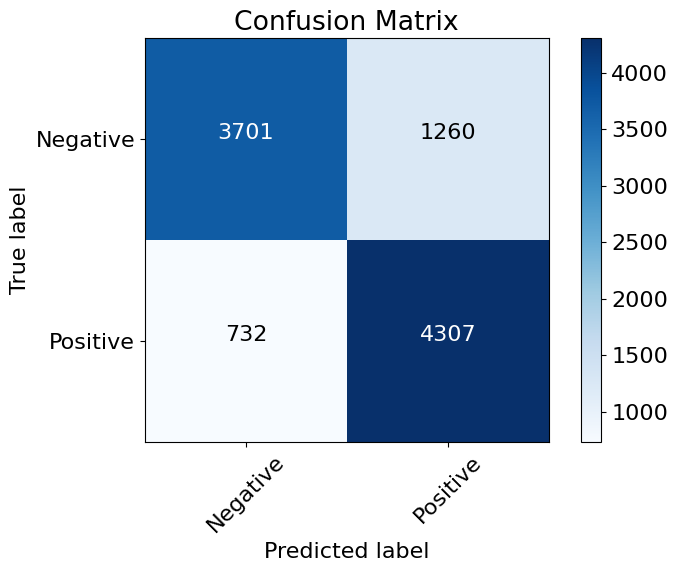

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cn = confusion_matrix(Y_test, y_pred)

# Define labels
labels = ['Negative', 'Positive']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Display numerical values within the plot
thresh = cn.max() / 2.
for i, j in itertools.product(range(cn.shape[0]), range(cn.shape[1])):
    plt.text(j, i, format(cn[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cn[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


---------------------------END--------------------------------------------------

---------------------------END--------------------------------------------------

---------------------------END--------------------------------------------------

In [ ]:
from sklearn.model_selection import train_test_split
def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
      ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
      indices.append(ids)

    return [indices, np.zeros_like(indices)], np.array(sentiments)

In [ ]:
data_train_,data_valid,label_train_,label_valid = train_test_split(data_train,label_train,test_size=0.15,random_state=48)

In [ ]:
test = pd.read_csv(path+'NTC_SV/NTC_SV_test_1.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()

In [ ]:
X_train,Y_train = load_data(data_train_,label_train_)
X_valid,Y_valid = load_data(data_valid,label_valid)
X_test,Y_test = load_data(data_test,label_test)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'256_checkpoint_lstm_data1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
import numpy as np

X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)
X_valid_np = np.array(X_valid)
Y_valid_np = np.array(Y_valid)

model.fit(X_train_np, Y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_valid_np, Y_valid_np), callbacks=callbacks_list)


In [ ]:
model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=[X_valid, Y_valid], callbacks=callbacks_list)

In [ ]:
model.load_weights(path+'256_checkpoint_lstm_data1.h5')

In [ ]:
y_pred =np.round(model.predict(X_test))

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
print(precision_score(Y_test,y_pred))
print(recall_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
cn = confusion_matrix(Y_test,y_pred,labels=labels)

In [ ]:
#@title plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()


In [ ]:
plot_confusion_matrix(cn,title='Data vreview',normalize=False,target_names=labels,path_file=path+'bert_lstm_vreview_cm.svg')